## Bionmial Distributions
Answers to exercises

Copyright 2019 by Joshua I. Gold, University of Pennsylvania
    
    Created 09/21/18
    
    Updated 12/31/19
    
    Ported to Python 03/29/21

In [32]:
import platform

# Output on system used for development/testing:
# 3.9.2
print(platform.python_version())

# Uncomment and run to clear workspace
%reset

3.9.2


In [6]:
import numpy as np
from scipy.stats import binom

# Exercise 1
# Note that omitting the semicolon at the end of a line causes the output to be shown in the Command Window.
n = 10                          # Number of available quanta
pRelease = 0.2                  # Release probabilty 
k = np.arange(11)               # Possible values of k (measured events)
probs = binom.pmf(k,n,pRelease) # Array of probabilities of obtaining those values of k, given n and prelease

# Print it nicely
for A, B in zip(k, probs):
    print(f'k={A:2d}: p={B:.2f}')

k= 0: p=0.11
k= 1: p=0.27
k= 2: p=0.30
k= 3: p=0.20
k= 4: p=0.09
k= 5: p=0.03
k= 6: p=0.01
k= 7: p=0.00
k= 8: p=0.00
k= 9: p=0.00
k=10: p=0.00


In [12]:
import numpy as np
from scipy.stats import binom

# Exercise 2
n = 14  # Number of available quanta
k = 8   # Measured number of released quanta

# Compute the pdf from a range of p values from 0.1 to 1.0 in 0.1-size steps
ps = np.arange(0.1, 1.0, 0.1)
probs = [binom.pmf(k,n,x) for x in ps]

# Print it nicely
for A, B in zip(ps, probs):
    print(f'p={A:.1f}: binomial probability={B:.4f}')


p=0.1: binomial probability=0.0000
p=0.2: binomial probability=0.0020
p=0.3: binomial probability=0.0232
p=0.4: binomial probability=0.0918
p=0.5: binomial probability=0.1833
p=0.6: binomial probability=0.2066
p=0.7: binomial probability=0.1262
p=0.8: binomial probability=0.0322
p=0.9: binomial probability=0.0013


total probability = 1.24e-07, total log probability = -15.905


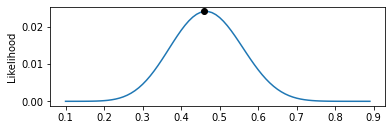

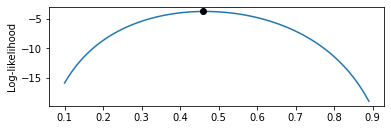

In [53]:
import numpy as np
import numpy.matlib as matlib
import matplotlib.pyplot as plt
from scipy.stats import binom

# Exercise 3
# Likelihood and log-likelihood for sample size = 2, assumed pRelease=0.1
n1 = 14             # Number of available quanta, experiment 1
n2 = 14             # Number of available quanta, experiment 2
k1 = 8              # Measured number of released experiment 1
k2 = 5              # Measured number of released experiment 2
pRelease = 0.1      # Assumed probability of release
prob1 = binom.pmf(k1,n1,pRelease) # Probabilty of obtaining data 1 (k1) given n1, prelease
prob2 = binom.pmf(k2,n2,pRelease) # Probabilty of obtaining data 2 (k2) given n2, prelease
total_probability = prob1 * prob2 # Assume independence and compute product
total_log_probability = np.log(prob1) + np.log(prob2) # Assume independence and compute sum
print(f'total probability = {total_probability:.3}, total log probability = {total_log_probability:.3f}')

# likelihood and log-likelihood functions for sample size = 2
ps = np.arange(0.1, 0.9, 0.01)      # Array of possible release probabilities -- compute at a resolution of 0.01

# Get value of the binomial distribution for each combination of k, n, p. The output is a matrix with two columns: 1) n1, k1  2) n2, k2. ows are different values of p
probs = binom.pmf(matlib.repmat([k1, k2], ps.size, 1), matlib.repmat([n1, n2], ps.size, 1), matlib.repmat(np.asmatrix(ps).T, 1, 2))

# The likelihood function is the product of likelihoods (assuming independence)
plt.subplot(211)
plt.ylabel('Likelihood')
likelihood_function = np.prod(probs,1)          # Compute the product for each row 
plt.plot(ps, likelihood_function)               # Plot it
max_likelihood = np.amax(likelihood_function)   #  Get the maximum likelihood
plt.plot(ps[likelihood_function==max_likelihood], max_likelihood, 'ko')
plt.show()

# The log-likelihood function is the sum of log-likelihoods (assuming independence)
plt.subplot(212)
plt.ylabel('Log-likelihood')
log_likelihood_function = np.sum(np.log(probs),1); # Compute the sum for each row
plt.plot(ps, log_likelihood_function)               # Plot it
max_log_likelihood = np.amax(log_likelihood_function)      # Get the maximum likelihood
plt.plot(ps[log_likelihood_function==max_log_likelihood], max_log_likelihood, 'ko')
plt.show()


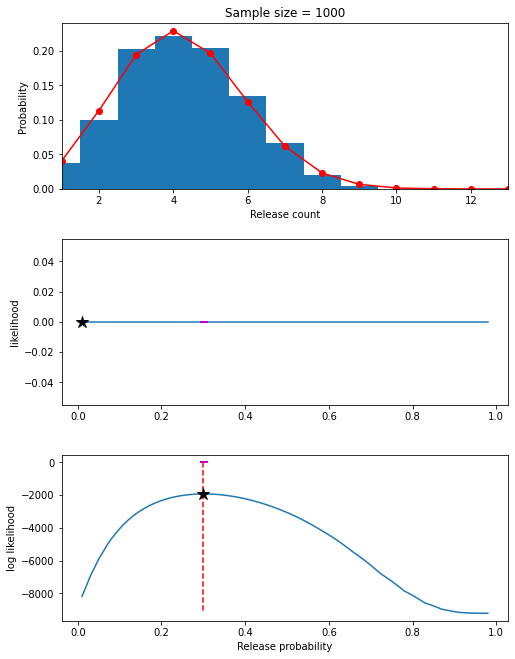

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import time
from scipy.stats import binom
from IPython.display import clear_output
from statsmodels.stats import proportion

# Likelihood and log-likelihood functions for different sample sizes.

# The code below will produce three plots that will update automatically for different sample sizes. You should see that as sample size increases, the ability to estimate the true value of the probability of release increases. You will also see an advantage of using log-likelihood over likelihood: as the number of samples increases, the total likelihood (the product of the likeilihoods associated with each measurement in the sample) eventually disappears, because Matlab can't handle the really small numbers (note that as the sample size increases, the number of all possible experimental outcomes you could measure gets really, really big, so the total likelihood of any GIVEN outcome gets really, really small). The three plots are:

# TOP: normalized histogram of simulated experimental outcomes (i.e., simulated values of k for the given release probability and sample size), along with the theoretical binomial distribution

# MIDDLE: likelihood function, p(simulated data | pRelease)
#  Also shown are the maximum likelihood (peak of the likelihood function) determined directly from the plotted likelihood function plus the value (and 95% confidence intervals) computed using Matlab's "binofit" function fit to the simulated data, plus the value of pRelease used in the simulations.

# BOTTOM: Same as in the middle panel, but using the log-likelihood function
fig, axs = plt.subplots(3, 1, figsize=(8, 11))
n = 14                              # number of available quanta
p_release = 0.3                      # assumed probability of release
ks = np.arange(0, n)                # possible values of k
ps = np.arange(0.01, 0.99, 0.01)    # possible release probabilities
#pdat = zeros(length(ps), 2)  # pre-allocate matrix to hold likelihoods per p
TINY = 0.0001                       # to avoid multiplying/taking logs of really small numbers
for sample_size in np.logspace(0,3,30):  # try different sample sizes

    # # Simulate experiments -- get simulated counts for the given n, pRelease, and number of experiments
    simulated_counts = binom.rvs(n, p_release, size=int(np.round(sample_size)))

    # Plot experiment, theoretical binomial pdf
    plt.sca(axs[0])
    axs[0].cla()
    plt.title(f'Sample size = {int(np.round(sample_size))}')
    plt.ylabel('Probability')
    plt.xlabel('Release count')
    plt.xlim((ks[1], ks[-1]))

    # Plot normalized histogram of simulated counts
    plt.hist(simulated_counts, np.arange(-0.5, n+0.5, 1), density=True)

    # Plot theoretical pdf
    plt.plot(ks, binom.pmf(ks, n, p_release), 'ro-')

    # compute (log) lik for each p
    likelihoods = np.zeros((ps.size, 2))

    # Loop through each possible value of release probability
    for p_index, p_value in enumerate(ps):
        
        # Compute the probabilities of obtaining the data, given the assumed release probabilty
        probs = binom.pmf(simulated_counts, n, p_value)
        
        # Avoid really small numbers
        probs[probs<TINY] = TINY

        # Save product of likelihoods and sum of log likelihoods
        likelihoods[p_index, 0] = np.prod(probs)
        likelihoods[p_index, 1] = np.sum(np.log(probs))

    # Get the 95% onfidence intervals for the maximum likelihood binomial fit value of p. This uses a trick that assumes all of the measurements are independent and lumps them together as if they were one big experiment.
    ci_low, ci_upp = proportion.proportion_confint(np.sum(simulated_counts), sample_size*n)

    # Plot product of likelihoods
    plt.sca(axs[1])
    axs[1].cla()    
    plt.ylabel('likelihood')

    # Plot the likelihood function (product of likelihoods)
    plt.plot(ps, likelihoods[:,0])

    # Find the maximum
    max_lik = np.max(likelihoods[:,0])

    # Show the actual pRelease value as a dashed line
    plt.plot([p_release, p_release], [0, max_lik], 'r--')

    # Show the 95% confidence intervals from the fits 
    plt.plot([ci_low, ci_upp], [max_lik, max_lik], 'm-', linewidth=2)

    # Show the maximum value of our computed likelihood function   
    plt.plot(ps[np.atleast_1d(np.argmax(likelihoods[:,0]))[0]], max_lik, 'k*', markersize=12)

    # plot sum of log-likelihoods
    plt.sca(axs[2])
    axs[2].cla()
    plt.ylabel('log likelihood')
    plt.xlabel('Release probability')
    # plt.axis((0, 1, np.log(TINY)*1000, 0))

    # Plot the likelihood function (sum of log-likelihoods)
    plt.plot(ps, likelihoods[:,1])

    # Find the maximum
    max_loglik = np.max(likelihoods[:,1])

    # Show the actual pRelease value as a dashed line
    plt.plot([p_release, p_release], [0, np.min(likelihoods[:,1])], 'r--')

    # Show the 95% confidence intervals from the fits 
    plt.plot([ci_low, ci_upp], [max_lik, max_lik], 'm-', linewidth=2)

    # Show the maximum value of our computed likelihood function
    plt.plot(ps[np.atleast_1d(np.argmax(likelihoods[:,1]))[0]], max_loglik, 'k*', markersize=12)

    # Make the figure look better
    plt.subplots_adjust(hspace=0.3)
    plt.show()

    # Wait
    # time.sleep(0.5)

    # Clear for next plot
    clear_output(wait=True)

In [25]:
import numpy as np
import numpy.matlib as matlib
from scipy.stats import binom

# Exercise 4

# Set up the experiment
counts = [0, 0, 3, 10, 19, 26, 16, 16, 5, 5, 0, 0, 0, 0, 0] # The experimental outcomes
n = len(counts)-1               # Number of available quanta in each experiment
ks = np.arange(n+1)             # Possible values of k
ps = np.arange(0, 1.01, 0.01)    # Possible values of release probability, as a column vector

# Compute the value of the binomial distribution for each possible value of k, n, p. Make a matrix in which:
#     - columns correspond to different values of p
#     - rows correspond to different values of k
probs = binom.pmf(matlib.repmat(ks, ps.size, 1), n, matlib.repmat(np.asmatrix(ps).T, 1, ks.size))

# Make a matrix of outcomes (in rows) that are repeated along the columns so we can use them to compute likelihoods for each possible value of release probability (p)
counts_matrix = matlib.repmat(counts, ps.size, 1)

# Compute likelihood function, which takes the product of all likelihoods associated with each measured outcome. 
likelihood_fcn = np.prod(probs ** counts_matrix, axis=1)
p_hat_from_liklihood = ps[np.argmax(likelihood_fcn)]

# Compute log-likelihood function, which takes the sum of all log-likelihoods associated with each measured outcome.
probs[probs<0.0001]=0.0001
log_likelihood_fcn = np.sum(np.log(probs) * counts_matrix, axis=1)
p_hat_from_log_likelihood = ps[np.argmax(log_likelihood_fcn)]

# Compute p directly from the empirical data
p_empirical = np.sum(counts*ks)/(np.sum(counts)*n)

# Show the results
print(f'p = {p_hat_from_liklihood:.3f} from likelihood, {p_hat_from_log_likelihood:.3f} from log-likelihood, {p_empirical:.3f} directly')

p = 0.380 from likelihood, 0.380 from log-likelihood, 0.382 directly


In [30]:
import numpy as np
import scipy.stats as st

# Exercise 5
n = 14               # Number of available quanta
k = 7                # Measured number of released quanta
p_hat = k/n           # Compute maximum-likelihood value of p
p_null = 0.3;         #  Null hypothesis p

# Get p-value for one-sided test that you would have gotten k or more successes in n trials for the given null hypothesis p
p_value = st.binom_test(k, n, p_null, alternative='greater')    

# Print result. Note that p>0.05, so cannot rule out that we would have gotten this measurement by chance under the null hypothesis
print(f'p value for the null hypothesis that p={p_null:.1f} = {p_value:.4f}')

p value for the null hypothesis that p=0.3 = 0.0933


row=0, goodness-of-fits, binomial p=0.992, Poisson p=0.950
row=1, goodness-of-fits, binomial p=0.849, Poisson p=0.833
row=2, goodness-of-fits, binomial p=0.999, Poisson p=0.891
row=3, goodness-of-fits, binomial p=0.988, Poisson p=0.200
row=4, goodness-of-fits, binomial p=0.760, Poisson p=0.015
row=5, goodness-of-fits, binomial p=1.000, Poisson p=0.000


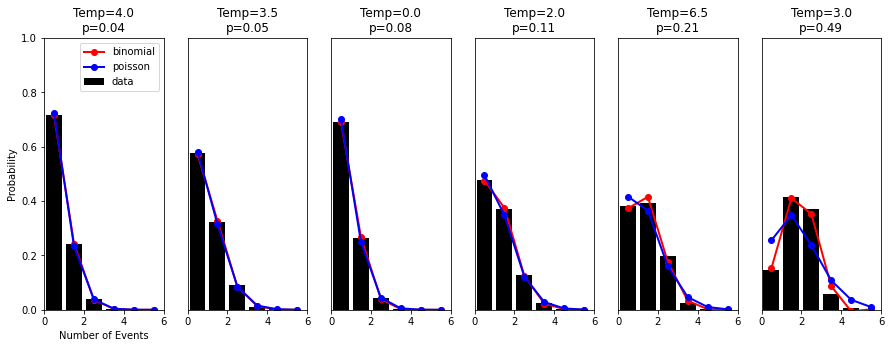

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.stats import chi2

# Bonus exercise
# Set up the figure
fig = plt.figure(figsize=(15,5))
# The data table
data = np.asarray([
   [4.0, 615, 206, 33,  2,  0, 0],
   [3.5, 604, 339, 94,  11, 2, 0],
   [0.0, 332, 126, 21,  1,  0, 0],
   [2.0, 573, 443, 154, 28, 2, 0],
   [6.5, 172, 176, 89,  12, 1, 0],
   [3.0, 80,  224, 200, 32, 4, 0]])

xs = np.arange(6) # x-axis

# For each session
for index, row in enumerate(data):

    # Compute relevant variables
    nx = row[1:]                  # the count data
    N  = np.sum(nx)               # the total number of trials
    m  = np.sum(nx[1:]*xs[1:])/N  # mean
    v  = np.sum((xs-m)**2*nx)/N   # variance
    p  = 1 - (v/m)                # release probabilty
    n  = m/p                      # available quanta per trial

    # Set up the plot
    ax = plt.subplot(1, len(data), index+1)
    plt.bar(xs+0.5, nx/N, facecolor='k')

    # Compute the binomial probabilities according to the equations at the top of p. 762
    binomial_counts = np.zeros(xs.size)
    binomial_counts[0] = np.sum(nx)*(1-p)**n

    for idx in np.arange(1, binomial_counts.size):
        binomial_counts[idx] = binomial_counts[idx-1]*(m-p*(idx-1))/((idx)*(1-p))
    binomial_counts = np.round(binomial_counts)

    # Normalize for pdf and plot
    plt.plot(xs+0.5, binomial_counts/np.sum(binomial_counts), 'ro-', markerfacecolor='r', linewidth=2)

    # Get Possion pdf
    pps = poisson.pmf(xs, m)
    plt.plot(xs+0.5, pps, 'bo-', markerfacecolor='b', linewidth=2)

    # Compute Chi-2 goodness-of-fit, k-1 degrees of freedom for binomial and Poisson
    # For binomial, use a little cheat: assume all bins contribute even when binomialCounts=0 (because nx is always zero then, too)
    with np.errstate(invalid='ignore', divide='ignore'):
        pb = 1-chi2.cdf(np.nansum(np.divide((nx-binomial_counts)**2, binomial_counts)), binomial_counts.size-1)
        poisson_counts = np.round(pps*N)
        pp = 1-chi2.cdf(np.nansum(np.divide((nx-poisson_counts)**2, poisson_counts)), poisson_counts.size-1)
    print(f'row={index}, goodness-of-fits, binomial p={pb:.3f}, Poisson p={pp:.3f}')

    # Show titles,labels, legend
    plt.axis([0, 6, 0, 1])
    plt.title(f'Temp={row[0]:.1f}\np={p:.2f}')
    if index == 0:
        plt.xlabel('Number of Events')
        plt.ylabel('Probability')
        plt.legend(('binomial', 'poisson', 'data'))
    else:
        ax.get_yaxis().set_ticks([])
